In [1]:
import numpy as np
import pandas as pd
import math
import time
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from model.LongShortTermMemory import LongShortTermMemory as LSTM

In [2]:
# init paramters
seed = 1
time_step = 7
batch_size = 128
learning_rate = 1e-3
hidden_size = 300 
n_layers = 2

# steup using GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# setuo random seed
torch.manual_seed(seed)

In [3]:
# load FinTech data
df = pd.read_csv('./data/FinTech.csv', encoding='utf-8')
df.head()

,Sentiment_24h,DXYUSD_Gain_Rate,World_Index_Gain_Rate,GoldUSD_Gain_Rate,Silver_Gain_Rate,DBCCommodity_Gain_Rate,DJCI_Gain_Rate,CrudeOil_Gain_Rate,SPY_Gain_Rate,VIX_Gain_Rate,TNXTbill_Gain_Rate,BTC_Price
0,0.188838,0.001341,0.003931,0.006341,0.006341,0.008765,0.019090,0.019418,0.003971,-0.000729,0.003007,117.00
1,0.169673,-0.005234,0.007311,-0.014732,-0.014732,-0.007181,-0.001202,-0.010167,0.002574,-0.013858,0.014537,103.43
2,0.131704,-0.000857,0.000000,-0.038969,-0.038969,-0.000387,-0.002442,-0.022024,-0.006590,0.043948,-0.011460,91.01
3,0.128927,0.007229,0.004812,0.009762,0.009762,0.008491,0.029350,0.032857,0.006743,-0.061464,-0.007304,118.33
4,0.157061,-0.001460,-0.012230,0.009474,0.009474,0.001896,-0.000804,0.017236,0.001427,-0.005418,0.076829,106.40


In [4]:
# Divide the data set into inputs and outputs
# df_input = df.drop(['Return'], axis=1).values
# df_ouput = df[['Return']].values

df_input = df.drop(['BTC_Price'], axis=1).values
df_ouput = df[['BTC_Price']].values

n_samples, n_features = df_input.shape
df_input.shape, df_ouput.shape

((1912, 11), (1912, 1))

In [5]:
# Normalized data (mean:0, std:1)
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_scaler = X_scaler.fit(df_input)
df_input = X_scaler.transform(df_input)

Y_scaler = Y_scaler.fit(df_ouput)
df_ouput = Y_scaler.transform(df_ouput)

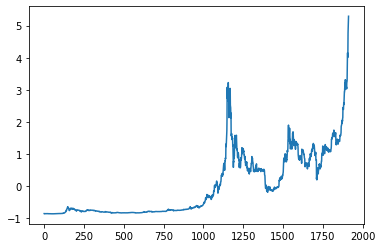

In [9]:
# import matplotlib.pyplot as plt
# plt.plot(df_ouput)

In [6]:
# built timeseries data for LSTM
X_data = np.zeros([n_samples-time_step+1, time_step, n_features])
Y_data = torch.Tensor(df_ouput[time_step-1:, :])
n_samples = X_data.shape[0]
X_data.shape, Y_data.shape

for i in range(n_samples):
    X_data[i, :, :] = df_input[i:i+time_step, :]
    
X_data = torch.Tensor(X_data)
X_data.shape, Y_data.shape

(torch.Size([1906, 7, 11]), torch.Size([1906, 1]))

In [7]:
# split data to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.25, random_state=1)
# make DataLoader for train and evaluation
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size, shuffle=False)
# for bath_id, batch_data in enumerate(train_loader):
#     print(bath_id, batch_data[0].shape)   # trian_data
#     print(bath_id, batch_data[1].shape)   # test_data

In [8]:
# built LSTM model
model = LSTM(time_step, n_features, hidden_size=hidden_size, n_layers=n_layers).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criteon = nn.MSELoss()

In [9]:
# 'R2 score'
def accuracy(preds, y):
    u = torch.sum(torch.square(y - preds))
    v = torch.sum(torch.square(y - torch.mean(y)))
    return 1 - (u/v)


def train(model, iterator, optimizer, criteon):
    
    avg_loss = []
    avg_acc = []
    model.train() 

    for batch_id, batch_data in enumerate(iterator):
        inputs, labels = batch_data
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred, _ = model(inputs)
#         print(pred.shape, labels.shape)
        loss = criteon(pred.squeeze(), labels.squeeze())
        acc = accuracy(pred.squeeze(), labels.squeeze()).item()

        avg_loss.append(loss.item())
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc


def evaluate(model, iterator, criteon):

    avg_loss = []
    avg_acc = []
    model.eval()
    att_weights = []
    with torch.no_grad():
        for batch_data in iterator:
            inputs, labels = batch_data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred, attention_weight = model(inputs)
            att_weights.append(attention_weight.squeeze())
            loss = criteon(pred.squeeze(), labels.squeeze())
            acc = accuracy(pred, labels).item()

            avg_loss.append(loss.item())
            avg_acc.append(acc)

    avg_loss = np.array(avg_loss).mean()
    avg_acc = np.array(avg_acc).mean()
    return avg_loss, avg_acc, att_weights

In [26]:
#train and print model
best_valid_acc = float('-inf')

epochs = 300
for epoch in range(epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criteon)
    dev_loss, dev_acc, att_weights = evaluate(model, test_loader, criteon)

    end_time = time.time()

    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if dev_acc > best_valid_acc: 
        best_valid_acc = dev_acc
        torch.save(model.state_dict(), 'lstm-model.pt')
    if epoch % 50 == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.6f} | Train Acc: {train_acc*100:.5f}%')
        print(f'\t Val. Loss: {dev_loss:.6f} |  Val. Acc: {dev_acc*100:.5f}%')


Epoch:  1 | Epoch Time: 0.0m 0.12s
	Train Loss: 0.321809 | Train Acc: 66.99929%
	 Val. Loss: 0.212647 |  Val. Acc: 79.89078%
Epoch: 51 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.258776 | Train Acc: 73.41375%
	 Val. Loss: 0.195225 |  Val. Acc: 81.57507%
Epoch: 101 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.255329 | Train Acc: 73.81249%
	 Val. Loss: 0.190940 |  Val. Acc: 81.97211%
Epoch: 151 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.272850 | Train Acc: 71.43554%
	 Val. Loss: 0.193418 |  Val. Acc: 81.90068%
Epoch: 201 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.277629 | Train Acc: 72.04070%
	 Val. Loss: 0.203409 |  Val. Acc: 80.78634%
Epoch: 251 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.256249 | Train Acc: 72.55836%
	 Val. Loss: 0.189239 |  Val. Acc: 82.06012%
Epoch: 300 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.281597 | Train Acc: 70.53236%
	 Val. Loss: 0.192516 |  Val. Acc: 81.77510%


In [27]:
# exchange timestep and n_features
new_X_data = X_data.transpose(1, 2)
new_X_data.shape

torch.Size([1906, 11, 7])

In [28]:
# split data to train and test set
X_train, X_test, Y_train, Y_test = train_test_split(new_X_data, Y_data, test_size=0.25, random_state=1)
# make DataLoader for train and evaluation
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size, shuffle=False)

In [29]:
# built LSTM model (exchanged n_feaures and time_step)
model = LSTM(n_features, time_step, hidden_size=hidden_size, n_layers=n_layers).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criteon = nn.MSELoss()

In [31]:
#train and print model
best_valid_acc = float('-inf')

epochs = 300
for epoch in range(epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criteon)
    dev_loss, dev_acc, att_weights = evaluate(model, test_loader, criteon)

    end_time = time.time()

    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if dev_acc > best_valid_acc: 
        best_valid_acc = dev_acc
        torch.save(model.state_dict(), 'lstm-model.pt')
    if epoch % 50 == 0 or epoch == epochs-1:
        print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.6f} | Train Acc: {train_acc*100:.5f}%')
        print(f'\t Val. Loss: {dev_loss:.6f} |  Val. Acc: {dev_acc*100:.5f}%')

Epoch:  1 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.279570 | Train Acc: 70.64274%
	 Val. Loss: 0.232963 |  Val. Acc: 77.99630%
Epoch: 51 | Epoch Time: 0.0m 0.13s
	Train Loss: 0.256321 | Train Acc: 73.52234%
	 Val. Loss: 0.191198 |  Val. Acc: 82.04569%
Epoch: 101 | Epoch Time: 0.0m 0.13s
	Train Loss: 0.284512 | Train Acc: 70.36568%
	 Val. Loss: 0.191175 |  Val. Acc: 82.10503%
Epoch: 151 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.257026 | Train Acc: 72.07293%
	 Val. Loss: 0.215432 |  Val. Acc: 79.87456%
Epoch: 201 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.241533 | Train Acc: 75.19717%
	 Val. Loss: 0.189500 |  Val. Acc: 82.25107%
Epoch: 251 | Epoch Time: 0.0m 0.10s
	Train Loss: 0.250400 | Train Acc: 73.95426%
	 Val. Loss: 0.185699 |  Val. Acc: 82.55267%
Epoch: 300 | Epoch Time: 0.0m 0.11s
	Train Loss: 0.233060 | Train Acc: 73.36713%
	 Val. Loss: 0.212430 |  Val. Acc: 80.07525%


In [32]:
dev_loss, dev_acc, att_weights = evaluate(model, test_loader, criteon)
att = torch.cat(att_weights, dim=0).cpu()
pd.DataFrame(att.numpy().sum(axis=0).reshape(-1, 1))
df_coef = pd.DataFrame(columns=['variable', 'coefficient'])
df_coef['variable'] = df.columns[:-1]
df_coef['coefficient'] = att.numpy().sum(axis=0)
# df_coef['abs_coefficient'] = df_coef['coefficient'].abs()
# sort by absolute value of coefficient
pd.set_option('display.max_rows',None)
df_coef.sort_values(by=['coefficient'], ascending=False)

,variable,coefficient
0,Sentiment_24h,204.175995
10,TNXTbill_Gain_Rate,45.139484
9,VIX_Gain_Rate,42.318916
8,SPY_Gain_Rate,41.416164
7,CrudeOil_Gain_Rate,38.141396
6,DJCI_Gain_Rate,31.085878
5,DBCCommodity_Gain_Rate,26.464375
4,Silver_Gain_Rate,19.716324
1,DXYUSD_Gain_Rate,14.089036
3,GoldUSD_Gain_Rate,11.992526
